<a href="https://colab.research.google.com/github/ArlexMR/ECE-614-DeepLearning/blob/main/%5CLab4%5CECE614_Lab4_Notebook_ArlexMarin_JohnMoore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 614 - DEEP LEARNING
## SPRING 2023
## LABORATORY 4
## JOHN MOORE and ARLEX MARIN

# Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.datasets import cifar100
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
from keras import regularizers
import math

# Define Functions

In [ ]:
def to_categorical(arr, num_classes):
  return np.eye(num_classes)[arr.flatten()]

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def plot_loss_acc_curves(ax, history):
  ax2 = ax.twinx()

  ax.plot(history.history['loss'], 'k', label = "Train")
  ax.plot(history.history['val_loss'], 'r', label = "Validation")
  ax.set_ylabel('loss')
  ax.set_xlabel('epoch')
  
  ax2.plot(history.history['accuracy'], '--k', label = "Train")
  ax2.plot(history.history['val_accuracy'],'--r', label = "Validation")
  ax2.set_ylabel('Accuracy')
  
  return ax, ax2

# Load Data

## Load all (coarse) classes and filter training subclasses  

In [ ]:
(x_train_all, y_train_all), (x_test_all, y_test_all) = cifar100.load_data("coarse")

class_names = {0: "aquatic mammals",
               1: "fish",
               2: "flowers",
               3: "food containers",
               4: "fruit and vegetables",
               5: "household electrical devices",
               6: "household furniture",
               7: "insects",
               8: "large carnivores",
               9: "large man-made outdoor things",
               10:"large natural outdoor scenes",
               11:"large omnivores and herbivores",
               12:"medium-sized mammals",
               13:"non-insect invertebrates",
               14:"people",
               15:"reptiles",
               16:"small mammals",
               17:"trees",
               18:"vehicles 1",
               19:"vehicles 2"
               }

#Filter sub classes
selected_classes     = ["aquatic mammals", "flowers", "food containers", "people", "vehicles 1"]
selected_codes       = [key for key in class_names.keys() if class_names[key] in selected_classes]
filter_train_indices = np.flatnonzero(np.in1d(y_train_all, selected_codes))
filter_test_indices  = np.flatnonzero(np.in1d(y_test_all, selected_codes))

# filtered train and test arrays
x_train_c, y_train = (x_train_all[filter_train_indices], y_train_all[filter_train_indices])
x_test_c, y_test   = (x_test_all[filter_test_indices], y_test_all[filter_test_indices]) 

169001437/169001437 [==============================] - 2s 0us/step


## Compute gray scale inputs and one-hot output 

In [ ]:
# Grayscale Images
x_train_g   = rgb2gray(x_train_c).reshape(-1,32,32,1)
x_train_g   = x_train_g.astype('float32')/255
x_test_g    = rgb2gray(x_test_c).reshape(-1,32,32,1)
x_test_g    = x_test_g.astype('float32')/255

# Categorical y
num_classes = len(selected_classes)

#mapper to reclassify label codes from 0 to num_classes   
reclass_mapper = dict(zip(np.unique(y_train),range(num_classes)))

y_train_reclass = np.vectorize(reclass_mapper.get)(y_train) # reclassify y labels on train data
y_test_reclass = np.vectorize(reclass_mapper.get)(y_test) # reclassify y labels on test data
y_train_cat = to_categorical(y_train_reclass, num_classes)
y_test_cat  = to_categorical(y_test_reclass, num_classes)


## Show sample images

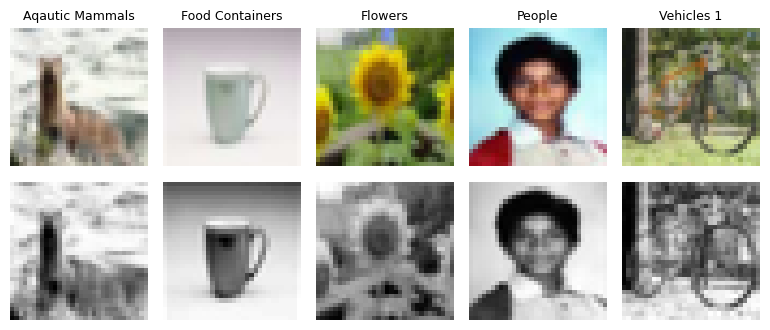

In [ ]:
f, axarr = plt.subplots(nrows=2, ncols=5, figsize = (7.8,3.5), sharex = True, sharey = True)
axarr[0][0].imshow(x_train_c[12]) # aquatic mammals RGB
axarr[0][1].imshow(x_train_c[2]) # food container RGB
axarr[0][2].imshow(x_train_c[3]) # flower RGB
axarr[0][3].imshow(x_train_c[0]) # people RGB
axarr[0][4].imshow(x_train_c[4]) # vehicle 1 RGB
axarr[1][0].imshow(x_train_g[12],cmap='gray') # aquatic mammals
axarr[1][1].imshow(x_train_g[2],cmap='gray') # food container
axarr[1][2].imshow(x_train_g[3],cmap='gray') # flower
axarr[1][3].imshow(x_train_g[0],cmap='gray') # people
axarr[1][4].imshow(x_train_g[4],cmap='gray') # vehicle 1
for i in range(2):
  for j in range(5):
    axarr[i][j].axis('off')
axarr[0][0].set_title('Aqautic Mammals', fontsize = 9);
axarr[0][1].set_title('Food Containers', fontsize = 9);
axarr[0][2].set_title('Flowers', fontsize = 9);
axarr[0][3].set_title('People', fontsize = 9);
axarr[0][4].set_title('Vehicles 1', fontsize = 9);
plt.xticks([])
plt.yticks([])
plt.tight_layout()

# Base model

## Compile model

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(8, (5,5), activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D((2,2), name='pool_1'))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2), name='pool_2'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                9232      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 8

## Train model

In [ ]:
batch_size = 128
epochs     = 50

history = model.fit(x_train_g,
                    y_train_cat,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(x_test_g,y_test_cat))

Epoch 1/50
98/98 [==============================] - 9s 88ms/step - loss: 1.5238 - accuracy: 0.3260 - val_loss: 1.4171 - val_accuracy: 0.4044
Epoch 2/50
98/98 [==============================] - 7s 71ms/step - loss: 1.3294 - accuracy: 0.4636 - val_loss: 1.3184 - val_accuracy: 0.4796
Epoch 3/50
98/98 [==============================] - 8s 83ms/step - loss: 1.2555 - accuracy: 0.5032 - val_loss: 1.2501 - val_accuracy: 0.5156
Epoch 4/50
98/98 [==============================] - 7s 68ms/step - loss: 1.2104 - accuracy: 0.5296 - val_loss: 1.2495 - val_accuracy: 0.5164
Epoch 5/50
98/98 [==============================] - 8s 81ms/step - loss: 1.1717 - accuracy: 0.5477 - val_loss: 1.2237 - val_accuracy: 0.5240
Epoch 6/50
98/98 [==============================] - 7s 68ms/step - loss: 1.1509 - accuracy: 0.5578 - val_loss: 1.1740 - val_accuracy: 0.5572
Epoch 7/50
98/98 [==============================] - 8s 81ms/step - loss: 1.1365 - accuracy: 0.5610 - val_loss: 1.1644 - val_accuracy: 0.5612
Epoch 8/50
98

## Plot loss curves

(0.3, 0.85)

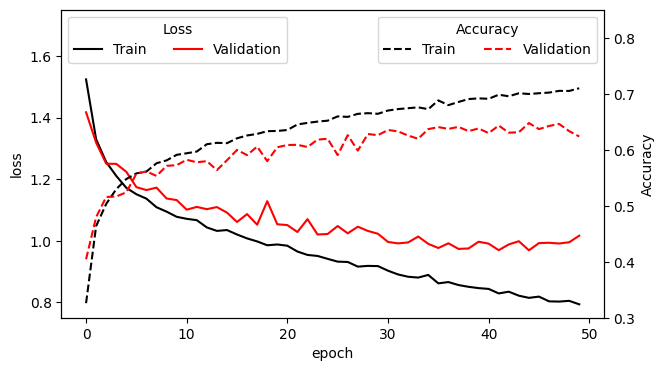

In [ ]:

fig, ax = plt.subplots(1,1, figsize = (7,4))

ax1, ax2 = plot_loss_acc_curves(ax, history)

ax1.legend(title = "Loss", loc = "upper left", ncol = 2)
ax2.legend(title = "Accuracy", loc = "upper right", ncol = 2)
ax1.set_ylim(0.75, 1.75)
ax2.set_ylim(0.3, 0.85)

## Feature Maps



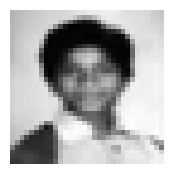

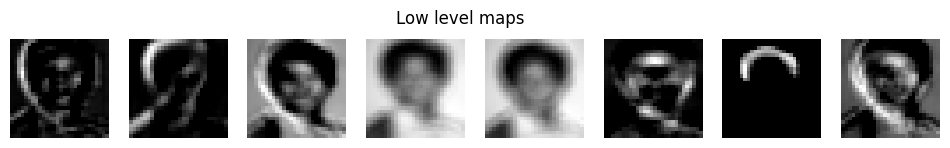

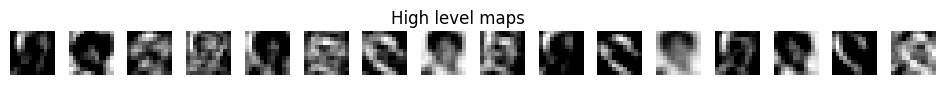

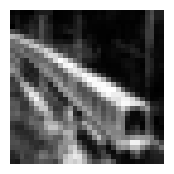

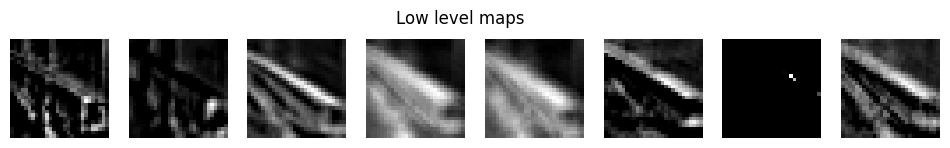

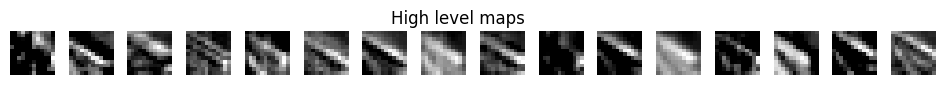

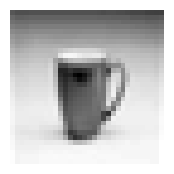

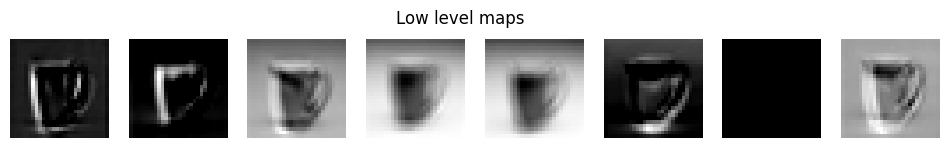

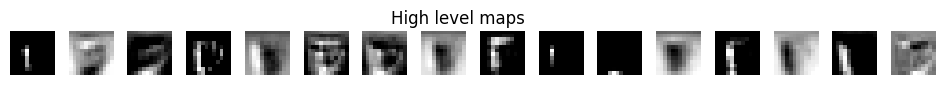

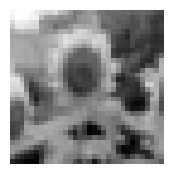

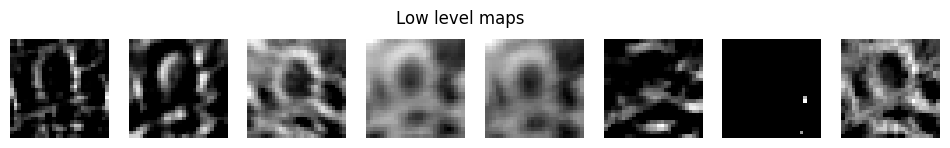

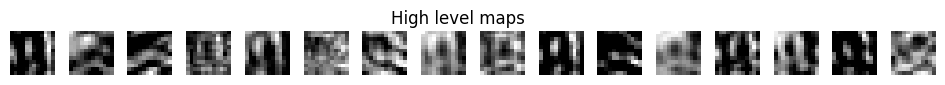

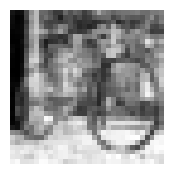

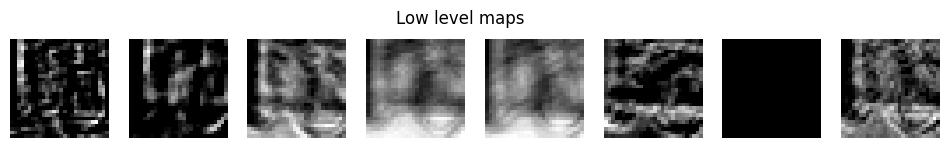

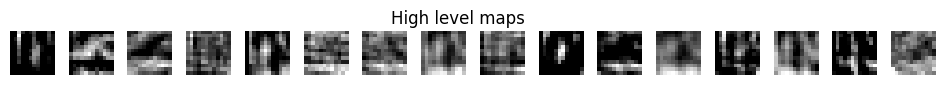

In [ ]:
low_level_layer = Model(inputs=model.input,
                        outputs=model.layers[0].output)

high_level_layer = Model(inputs=model.input,
                         outputs = model.layers[2].output)

sample_set = 5

low_level_features = low_level_layer.predict(x_train_g[:sample_set])
high_level_features = high_level_layer.predict(x_train_g[:sample_set])

n_low_level_maps  = low_level_features.shape[-1]
n_high_level_maps = high_level_features.shape[-1]

for sample in range(sample_set):
    
    plt.figure(figsize = (2,2))
    plt.imshow(x_train_g[sample][:,:,0], cmap = "gray")
    plt.axis('off')
    plt.show()
    fig = plt.figure(figsize=[12,12/n_low_level_maps])
    for i in range(n_low_level_maps):
        
        feature_map = low_level_features[sample, :, :, i]

        plt.subplot(1, n_low_level_maps, i+1)
        plt.imshow(feature_map, interpolation='none',cmap = "gray")
        plt.axis('off')
        plt.suptitle("Low level maps")
    plt.subplots_adjust(top = 0.8)

    fig = plt.figure(figsize = (12, 12/n_high_level_maps))
    for i in range(n_high_level_maps):

        feature_map = high_level_features[sample, :, :, i]

        plt.subplot(1, n_high_level_maps, i+1)
        plt.imshow(feature_map, interpolation='none', cmap = "gray")
        plt.axis('off')
        plt.suptitle("High level maps")
    plt.subplots_adjust(top = 0.7)


        

# Task 1

## Model Architecture

The function `get_model_task_1` creates a model with one conv2D layer with 8 5x5-filters (same as the base model) followed by a number of Max pooling layers defined by a list of `pool_sizes`. After the pool layers, a fully connected 16-units layer is added followed by a softmax output layer.  

Dropout layers can also be included after conv2D and maxPool layers

In [ ]:
def get_model_task_1(pool_sizes, output_size = 5, add_dropout = True):
  K.clear_session()
  model = Sequential()
  model.add(Conv2D(8, (5,5), activation='relu', input_shape=(32,32,1)))
  if add_dropout:
    model.add(Dropout(0.2))
  
  for i, pool_size in enumerate(pool_sizes):
    model.add(MaxPooling2D((pool_size,pool_size), name=f'pool_{i}'))
    if add_dropout:
      model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(output_size, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model



In [ ]:
pool_sizes = [2,3] # pool_size for each pooling layer. length of pool_sizes defines the number of pooling layers

model = get_model_task_1(pool_sizes, output_size = 5)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 8)         0         
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 4, 4, 8)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

## Test several variations

In [ ]:
pool_sizes_list = [[2],
                   [3],
                   [2,2],
                   [3,3]
                   ]
add_dropout_list = [True, False, True, False]

epochs     = 75
batch_size = 128

# Compile models
models = []
for pool_sizes, dropout in zip(pool_sizes_list, add_dropout_list):
  model = get_model_task_1(pool_sizes, output_size = 5, add_dropout = dropout)
  models.append(model)

# Train models
histories  = []
for i, model in enumerate(models):
  print(f"\nTraining model {i+1}/{len(models)}")
  history = model.fit(x_train_g,
                      y_train_cat,
                      epochs          = epochs,
                      batch_size      = batch_size,
                      verbose         = 1,
                      validation_data = (x_test_g,y_test_cat))

  histories.append(history)


Training model 1/4
Epoch 1/75
98/98 [==============================] - 9s 88ms/step - loss: 1.5195 - accuracy: 0.3218 - val_loss: 1.4405 - val_accuracy: 0.4064
Epoch 2/75
98/98 [==============================] - 7s 71ms/step - loss: 1.3635 - accuracy: 0.4434 - val_loss: 1.3360 - val_accuracy: 0.4776
Epoch 3/75
98/98 [==============================] - 8s 85ms/step - loss: 1.2711 - accuracy: 0.4976 - val_loss: 1.2771 - val_accuracy: 0.5024
Epoch 4/75
98/98 [==============================] - 7s 72ms/step - loss: 1.2049 - accuracy: 0.5364 - val_loss: 1.2251 - val_accuracy: 0.5280
Epoch 5/75
98/98 [==============================] - 8s 86ms/step - loss: 1.1646 - accuracy: 0.5541 - val_loss: 1.1910 - val_accuracy: 0.5592
Epoch 6/75
98/98 [==============================] - 8s 85ms/step - loss: 1.1277 - accuracy: 0.5722 - val_loss: 1.1800 - val_accuracy: 0.5532
Epoch 7/75
98/98 [==============================] - 7s 72ms/step - loss: 1.1029 - accuracy: 0.5782 - val_loss: 1.1408 - val_accuracy: 

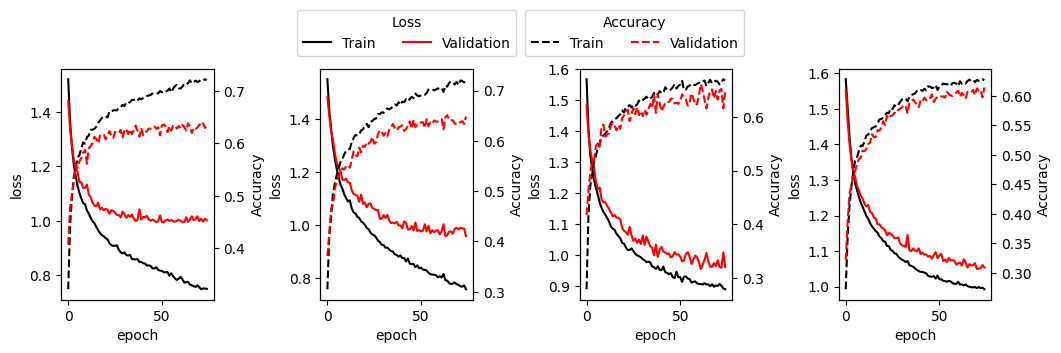

In [ ]:
#@title Plot loss curves
n_histories = len(histories)
fig, axs = plt.subplots(1,n_histories, figsize = (12,3))


loss_ylim = (1.4, 1.65)
acc_ylim = (0.25, 0.5)
for ax, history in zip(axs,histories):
  ax1, ax2 = plot_loss_acc_curves(ax, history)
  # ax1.set_ylim(loss_ylim)
  # ax2.set_ylim(acc_ylim)


fig.subplots_adjust(wspace = 0.7)
fig.legend(ax1.get_legend_handles_labels()[0],ax1.get_legend_handles_labels()[1], 
           title = "Loss", 
           ncol =2,
           bbox_to_anchor = (0.51, 1.1)
           )
fig.legend(ax2.get_legend_handles_labels()[0],ax2.get_legend_handles_labels()[1], 
           title = "Accuracy", 
           ncol =2,
           bbox_to_anchor = (0.7, 1.1)
           )

In [ ]:
#@title Hyperparameter table
df = pd.DataFrame({ 'N pool layers': map(len, pool_sizes_list),
                    'Pool size'    : [str(sizes) for sizes in pool_sizes_list],
                    'Dropout'      : ['Yes' if dropout else "No" for i, dropout in enumerate(add_dropout_list) ]
                  })
df.index = pd.Series(range(len(pool_sizes_list))).rename("Model ID")
df

,N pool layers,Pool size,Dropout
Model ID,,,
0,1,[2],Yes
1,1,[3],No
2,2,"[2, 2]",Yes
3,2,"[3, 3]",No


# Task 2

## Model Architecture

The function `get_model_task_2` creates a model with sequential couples of conv2D and maxPool layers. `kernel_sizes` and `filter_sizes` defines the dimensions of the conv2D outputs. These should be 3-element lists (to create a sequence of three pairs of conv2D and MaxPool layers) according to lab requeriments. The `pool size` is constant across layers (*default = 2*) and `dropout` layers are optional. If included, they are added after each conv2D layer

The fully connected layers at the end are equal to the base model on task 1     

In [ ]:
def get_model_task_2(kernel_sizes, filter_sizes, pool_size = 2, output_size = 5, add_dropout = True):
  K.clear_session()
  model = Sequential()

  model.add(Conv2D(filter_sizes[0], (kernel_sizes[0],kernel_sizes[0]), activation='relu', input_shape=(32,32,1)))
  if add_dropout:
    model.add(Dropout(0.2))
  model.add(MaxPooling2D((pool_size, pool_size), name= 'pool_0'))
  
  for i, (kernel_size, filter_size) in enumerate(zip(kernel_sizes[1:], filter_sizes[1:])):

    model.add(Conv2D(filter_size, (kernel_size,kernel_size), activation='relu'))
    if add_dropout:
      model.add(Dropout(0.2))
    model.add(MaxPooling2D((pool_size,pool_size)))

  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(output_size, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [ ]:
kernel_sizes = [3,3,3]
filter_sizes = [4,8,16]

model = get_model_task_2(kernel_sizes, filter_sizes, pool_size = 2, output_size = 5)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 4)         40        
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 4)         0         
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 8)         296       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 16)          1

## Test several variations

In [ ]:
kernel_sizes_list = [ [2,2,2],
                      [3,3,3],
                      [5,3,3]
                     ]
filter_sizes_list = [ [16,8,4],
                      [8,8,8],
                      [16,8,4] 
                    ]
add_dropout_list = [True, True, True]

epochs     = 75
batch_size = 128

# Compile models
models = []
for kernel_sizes, filter_sizes, dropout in zip(kernel_sizes_list, filter_sizes_list, add_dropout_list):
  model = get_model_task_2(kernel_sizes, filter_sizes, pool_size = 2, output_size = 5, add_dropout = dropout)
  models.append(model)

# Train models
histories  = []
for i, model in enumerate(models):
  print(f"\nTraining model {i+1}/{len(models)}")
  history = model.fit(x_train_g,
                      y_train_cat,
                      epochs          = epochs,
                      batch_size      = batch_size,
                      verbose         = 1,
                      validation_data = (x_test_g,y_test_cat))

  histories.append(history)


Training model 1/3
Epoch 1/75
98/98 [==============================] - 10s 96ms/step - loss: 1.6071 - accuracy: 0.2031 - val_loss: 1.6057 - val_accuracy: 0.2508
Epoch 2/75
98/98 [==============================] - 10s 99ms/step - loss: 1.5815 - accuracy: 0.2845 - val_loss: 1.5712 - val_accuracy: 0.3232
Epoch 3/75
98/98 [==============================] - 10s 99ms/step - loss: 1.5084 - accuracy: 0.3463 - val_loss: 1.5265 - val_accuracy: 0.3396
Epoch 4/75
98/98 [==============================] - 10s 98ms/step - loss: 1.4468 - accuracy: 0.3824 - val_loss: 1.4804 - val_accuracy: 0.3896
Epoch 5/75
98/98 [==============================] - 9s 90ms/step - loss: 1.4197 - accuracy: 0.3998 - val_loss: 1.4660 - val_accuracy: 0.4068
Epoch 6/75
98/98 [==============================] - 10s 99ms/step - loss: 1.3978 - accuracy: 0.4177 - val_loss: 1.4518 - val_accuracy: 0.4160
Epoch 7/75
98/98 [==============================] - 10s 99ms/step - loss: 1.3771 - accuracy: 0.4353 - val_loss: 1.4374 - val_accu

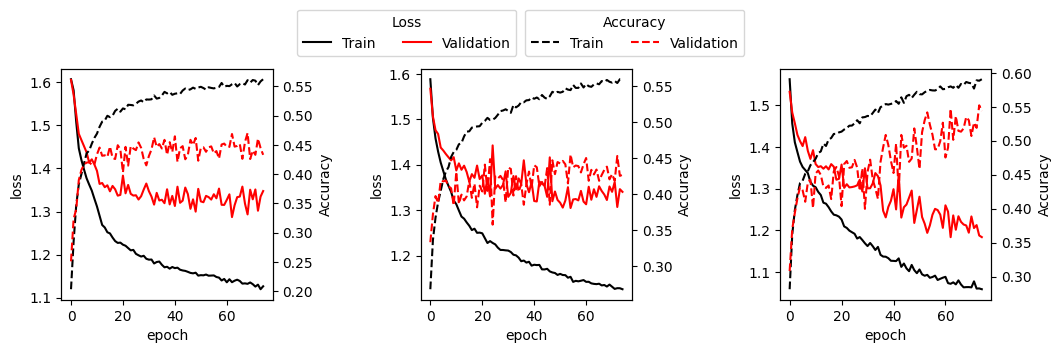

In [ ]:
#@title Plot loss curves
n_histories = len(histories)
fig, axs = plt.subplots(1,n_histories, figsize = (12,3))


for ax, history in zip(axs,histories):
  ax1, ax2 = plot_loss_acc_curves(ax, history)

fig.subplots_adjust(wspace = 0.7)
fig.legend(ax1.get_legend_handles_labels()[0],ax1.get_legend_handles_labels()[1], 
           title = "Loss", 
           ncol =2,
           bbox_to_anchor = (0.51, 1.1)
           )
fig.legend(ax2.get_legend_handles_labels()[0],ax2.get_legend_handles_labels()[1], 
           title = "Accuracy", 
           ncol =2,
           bbox_to_anchor = (0.7, 1.1)
           )

In [ ]:
#@title Hyperparameter Table
df = pd.DataFrame({ 'Kernel Size per layer' : [str(Ksizes) for Ksizes in kernel_sizes_list],
                    'N° Filters per layer ' : [str(Nfilters) for Nfilters in filter_sizes_list],
                    'Dropout              ' : ['Yes' if dropout else "No" for i, dropout in enumerate(add_dropout_list) ]
                  })
df.index = pd.Series(range(len(kernel_sizes_list))).rename("Model ID")
df

,Kernel Size per layer,N° Filters per layer,Dropout
Model ID,,,
0,"[2, 2, 2]","[16, 8, 4]",Yes
1,"[3, 3, 3]","[8, 8, 8]",Yes
2,"[5, 3, 3]","[16, 8, 4]",Yes


# Task 3

## Model Architecture

The function `get_model_task_3` takes the base model and adds `Dense` layers at the end according to the `dense_sizes` list. Each element in `dense_sizes` defines the number of units in the layer. optional `Dropout` layers can be included after each `Dense` layer 

A final `softmax` layer is automatically included

In [ ]:
def get_model_task_3(dense_sizes, output_size = 5, add_dropout = True):
  K.clear_session()
  model = Sequential()
  model.add(Conv2D(8, (5,5), activation='relu', input_shape=(32,32,1)))
  model.add(MaxPooling2D((2,2), name='pool_1'))
  model.add(Conv2D(16, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), name='pool_2'))
  model.add(Flatten())

  for dense_size in dense_sizes:
    model.add(Dense(dense_size, activation='relu', kernel_regularizer = regularizers.l2(0.01)))
    if add_dropout:
      model.add(Dropout(0.4))
  model.add(Dense(output_size, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


  return model

In [ ]:
dense_sizes = [32,16,8]

model = get_model_task_3(dense_sizes, output_size = 5)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                18464     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

## Test Several variations

In [ ]:
#Testing parameters
dense_sizes_list = [[16, 8],
                    [32, 16],
                    [32, 16, 8]
                    ]
                    

add_dropout_list = [True, True, True]

epochs     = 75
batch_size = 128


# Compile models
models = []
for dense_sizes, dropout in zip(dense_sizes_list, add_dropout_list):
  model = get_model_task_3(dense_sizes, output_size = 5, add_dropout = True)
  models.append(model)

# Train models
histories  = []
for i, model in enumerate(models):
  print(f"\nTraining model {i+1}/{len(models)}")
  history = model.fit(x_train_g,
                      y_train_cat,
                      epochs          = epochs,
                      batch_size      = batch_size,
                      verbose         = 1,
                      validation_data = (x_test_g,y_test_cat))

  histories.append(history)


Training model 1/3
Epoch 1/75
98/98 [==============================] - 9s 83ms/step - loss: 1.8197 - accuracy: 0.2080 - val_loss: 1.6977 - val_accuracy: 0.1996
Epoch 2/75
98/98 [==============================] - 7s 72ms/step - loss: 1.6614 - accuracy: 0.2268 - val_loss: 1.6182 - val_accuracy: 0.2832
Epoch 3/75
98/98 [==============================] - 7s 75ms/step - loss: 1.6009 - accuracy: 0.2769 - val_loss: 1.5607 - val_accuracy: 0.3204
Epoch 4/75
98/98 [==============================] - 8s 81ms/step - loss: 1.5586 - accuracy: 0.3116 - val_loss: 1.5114 - val_accuracy: 0.3592
Epoch 5/75
98/98 [==============================] - 7s 67ms/step - loss: 1.5316 - accuracy: 0.3246 - val_loss: 1.4835 - val_accuracy: 0.3712
Epoch 6/75
98/98 [==============================] - 8s 81ms/step - loss: 1.5062 - accuracy: 0.3358 - val_loss: 1.4601 - val_accuracy: 0.3824
Epoch 7/75
98/98 [==============================] - 7s 67ms/step - loss: 1.4823 - accuracy: 0.3538 - val_loss: 1.4380 - val_accuracy: 

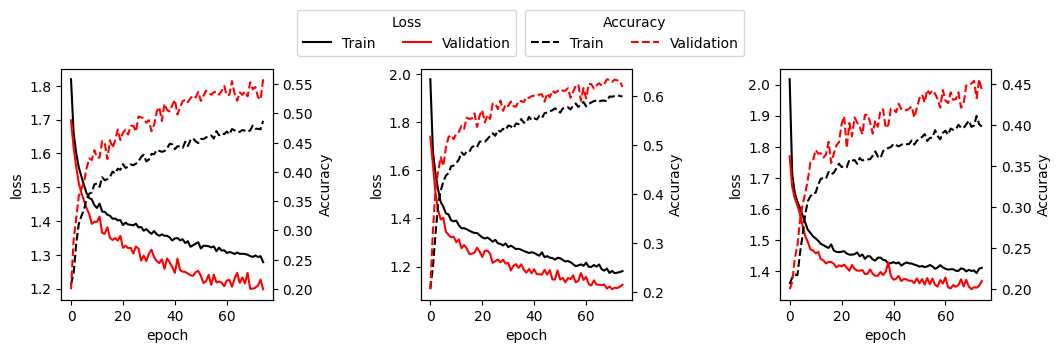

In [ ]:
#@title Plot Loss curves
n_histories = len(histories)
fig, axs = plt.subplots(1,n_histories, figsize = (12,3))


for ax, history in zip(axs,histories):
  ax1, ax2 = plot_loss_acc_curves(ax, history)

fig.subplots_adjust(wspace = 0.7)
fig.legend(ax1.get_legend_handles_labels()[0],ax1.get_legend_handles_labels()[1], 
           title = "Loss", 
           ncol =2,
           bbox_to_anchor = (0.51, 1.1)
           )
fig.legend(ax2.get_legend_handles_labels()[0],ax2.get_legend_handles_labels()[1], 
           title = "Accuracy", 
           ncol =2,
           bbox_to_anchor = (0.7, 1.1)
           )

In [ ]:
#@title Hyperparameter Table


df = pd.DataFrame({ 'N Dense layers'        : map(len, dense_sizes_list),
                    'N° neurons per layer ' : [str(sizes) for sizes in dense_sizes_list],
                    'Dropout              ' : ['Yes' if dropout else "No" for i, dropout in enumerate(add_dropout_list) ]
                  })
df.index = pd.Series(range(len(dense_sizes_list))).rename("Model ID")
df

,N Dense layers,N° neurons per layer,Dropout
Model ID,,,
0,2,"[16, 8]",Yes
1,2,"[32, 16]",Yes
2,3,"[32, 16, 8]",Yes


# Task 4

## Selected Model

Best performing model is the second model from Task 3 since it lacks signs of overfitting and shows high validation accuracy .  
Feature maps are constructed for the first and second convolutional layers (index 0 and 2)

In [ ]:
'''best_model = get_model_task_3(dense_sizes = [32, 16], output_size = 5, add_dropout = True)
best_model.summary()
epochs     = 75
batch_size = 128
history = best_model.fit(x_train_g,
                      y_train_cat,
                      epochs          = epochs,
                      batch_size      = batch_size,
                      verbose         = 1,
                      validation_data = (x_test_g,y_test_cat))'''

In [ ]:
best_model = histories[1].model 

low_level_layer = Model(inputs=best_model.input,
                        outputs=best_model.layers[0].output)

high_level_layer = Model(inputs=model.input,
                         outputs = model.layers[2].output)

## Feature maps

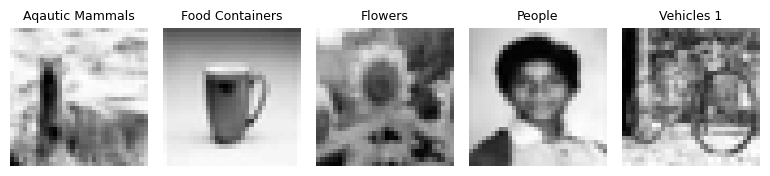

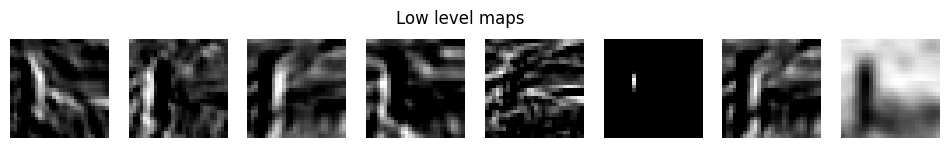

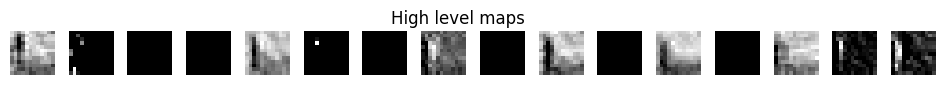

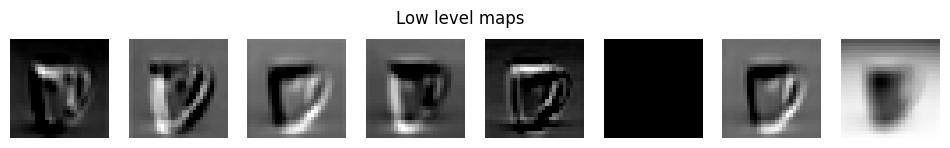

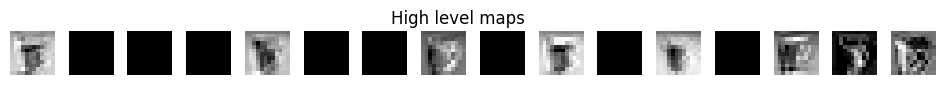

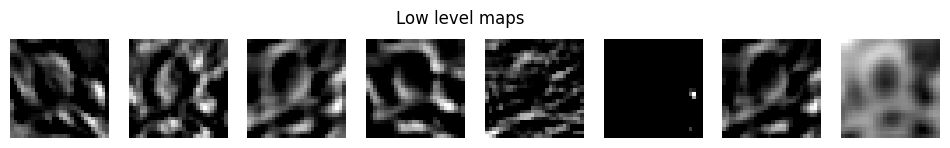

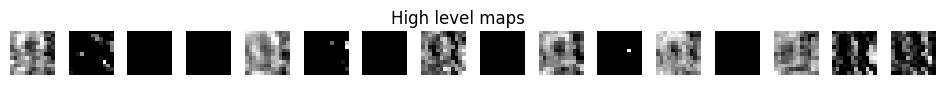

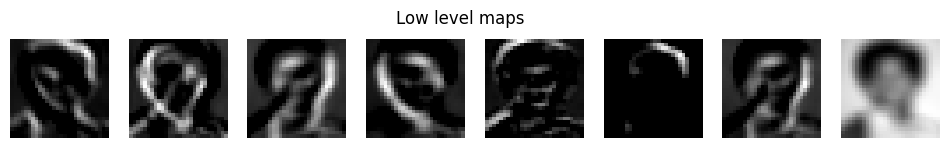

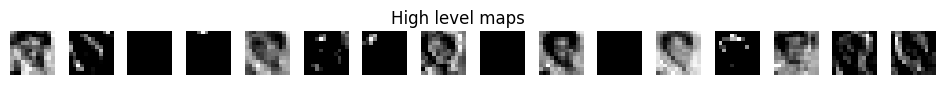

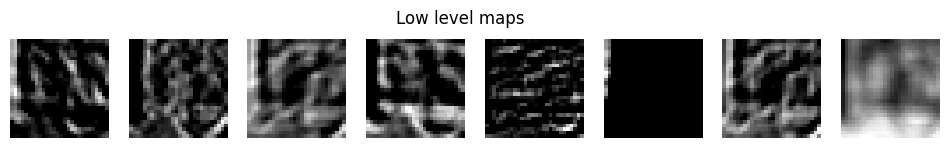

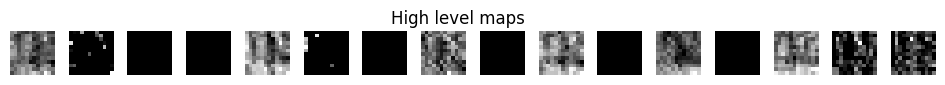

In [ ]:
f, axarr = plt.subplots(nrows=1, ncols=5, figsize = (7.8,3.5), sharex = True, sharey = True)
axarr[0].imshow(x_train_g[12],cmap='gray') # aquatic mammals
axarr[1].imshow(x_train_g[2],cmap='gray') # food container
axarr[2].imshow(x_train_g[3],cmap='gray') # flower
axarr[3].imshow(x_train_g[0],cmap='gray') # people
axarr[4].imshow(x_train_g[4],cmap='gray') # vehicle 1
for j in range(5):
  axarr[j].axis('off')
axarr[0].set_title('Aqautic Mammals', fontsize = 9);
axarr[1].set_title('Food Containers', fontsize = 9);
axarr[2].set_title('Flowers', fontsize = 9);
axarr[3].set_title('People', fontsize = 9);
axarr[4].set_title('Vehicles 1', fontsize = 9);
plt.xticks([])
plt.yticks([])
plt.tight_layout()

sample_set = [12,2,3,0,4]

low_level_features = low_level_layer.predict(x_train_g[:13])
high_level_features = high_level_layer.predict(x_train_g[:13])

n_low_level_maps  = low_level_features.shape[-1]
n_high_level_maps = high_level_features.shape[-1]

for sample in sample_set:
  #plt.figure(figsize = (2,2))
  #plt.imshow(x_train_g[sample][:,:,0], cmap = "gray")
  #plt.axis('off')
  #plt.show()

  fig = plt.figure(figsize=[12,12/n_low_level_maps])
  for i in range(n_low_level_maps):
      feature_map = low_level_features[sample, :, :, i]
      plt.subplot(1, n_low_level_maps, i+1)
      plt.imshow(feature_map, interpolation='none',cmap = "gray")
      plt.axis('off')
      plt.suptitle("Low level maps")
  plt.subplots_adjust(top = 0.8)

  fig = plt.figure(figsize = (12, 12/n_high_level_maps))
  for i in range(n_high_level_maps):
      feature_map = high_level_features[sample, :, :, i]
      plt.subplot(1, n_high_level_maps, i+1)
      plt.imshow(feature_map, interpolation='none', cmap = "gray")
      plt.axis('off')
      plt.suptitle("High level maps")
  plt.subplots_adjust(top = 0.7)

# Task 5



## Model Architecture
Model architecture defined according to the second model on Task 3, but in this case the output must be a 20-neuron layer. 

In [ ]:
model = get_model_task_3(dense_sizes = [32, 16], output_size = 20, add_dropout = True)

## Prepare data

In [ ]:
# Grayscale Images
x_train_all_g   = rgb2gray(x_train_all).reshape(-1,32,32,1)
x_train_all_g   = x_train_all_g.astype('float32')/255
x_test_all_g    = rgb2gray(x_test_all).reshape(-1,32,32,1)
x_test_all_g    = x_test_all_g.astype('float32')/255

# Categorical y
num_classes = 20

y_train_all_cat = to_categorical(y_train_all, num_classes)
y_test_all_cat  = to_categorical(y_test_all, num_classes)


## Train model

In [ ]:
batch_size = 128
epochs     = 100

history = model.fit(x_train_all_g,
                    y_train_all_cat,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    verbose         = 1,
                    validation_data = (x_test_all_g,y_test_all_cat))

Epoch 1/100
391/391 [==============================] - 24s 60ms/step - loss: 3.0981 - accuracy: 0.0577 - val_loss: 2.9731 - val_accuracy: 0.0889
Epoch 2/100
391/391 [==============================] - 19s 48ms/step - loss: 2.9519 - accuracy: 0.0826 - val_loss: 2.8944 - val_accuracy: 0.1171
Epoch 3/100
391/391 [==============================] - 19s 48ms/step - loss: 2.9143 - accuracy: 0.0948 - val_loss: 2.8563 - val_accuracy: 0.1180
Epoch 4/100
391/391 [==============================] - 18s 46ms/step - loss: 2.8981 - accuracy: 0.1020 - val_loss: 2.8448 - val_accuracy: 0.1312
Epoch 5/100
391/391 [==============================] - 20s 51ms/step - loss: 2.8812 - accuracy: 0.1098 - val_loss: 2.8182 - val_accuracy: 0.1381
Epoch 6/100
391/391 [==============================] - 18s 46ms/step - loss: 2.8680 - accuracy: 0.1152 - val_loss: 2.8056 - val_accuracy: 0.1411
Epoch 7/100
391/391 [==============================] - 20s 51ms/step - loss: 2.8605 - accuracy: 0.1167 - val_loss: 2.7977 - val_ac

## Loss Curves

(0.0, 0.3)

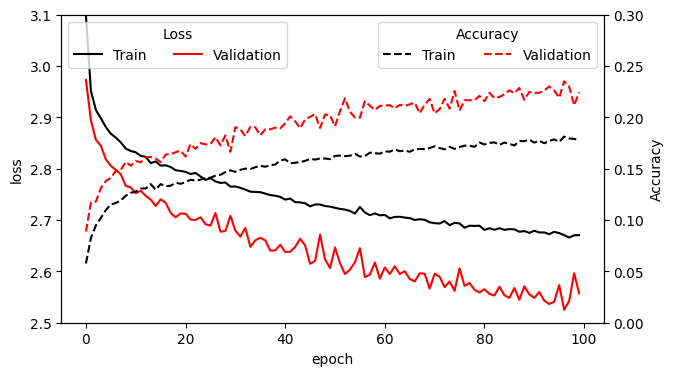

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7,4))

ax1, ax2 = plot_loss_acc_curves(ax, history)

ax1.legend(title = "Loss", loc = "upper left", ncol = 2)
ax2.legend(title = "Accuracy", loc = "upper right", ncol = 2)
ax1.set_ylim(2.5, 3.1)
ax2.set_ylim(0, 0.3)